# Final Project - News categorization

### Can we identify the type of news based on headlines and short descriptions?
### The purpose of this project under unsupervised learning course is to use NMF (Non-negative Matrix Factorization) to reduce the dimension and create the clusters. 
### We will use "News Category Dataset" provided by Kaggle. (https://www.kaggle.com/datasets/rmisra/news-category-dataset). This dataset contains around 210k news headlines from 2012 to 2022 from HuffPost. 
### Finally I will check the accuracy of clustering in comparison with the category in the dataset. 

# 1. Data Loading

In [1]:
import os
import numpy as np
import pandas as pd
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt

import re
!pip install nltk
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits
import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
import itertools
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords') 
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fam_i\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fam_i\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fam_i\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
reviews = pd.read_json("C:/Users/fam_i/OneDrive/Colorado/ML2_unsupervised/module5/News_Category_Dataset_v3.json", lines=True)
#reviews = pd.read_json("/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json", lines = True)

In [3]:
reviews.head()

link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23  
3 2022-09-23  
4 2022-09-22

### Each record in the dataset consists of the following attributes:
### 1) category: category in which the article was published.
### 2) headline: the headline of the news article.
### 3) authors: list of authors who contributed to the article.
### 4) link: link to the original news article.
### 5) short_description: Abstract of the news article.
### 6) date: publication date of the article.
### There are a total of 42 news categories in the dataset.

# 2. Exploratory Data Analysis

## - Check the categories: 42 categories in 209526 articles, in each category, there is not any null data.

In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [47]:
reviews['category'].value_counts()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

## - Concatonate 'headline' and 'short description'

In [5]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

## - Check the duplicate articles and remove

In [49]:
print(reviews[reviews.duplicated()])

                                                     link  \
67677   https://www.huffingtonpost.comhttp://www.mothe...   
67923   https://www.huffingtonpost.comhttp://gizmodo.c...   
70239   https://www.huffingtonpost.comhttp://www.cnbc....   
139830  https://www.huffingtonpost.comhttp://www.cnn.c...   
144409  https://www.huffingtonpost.comhttp://www.upwor...   
145142  https://www.huffingtonpost.comhttp://www.weath...   
178155  https://www.huffingtonpost.comhttp://www.busin...   
187329  https://www.huffingtonpost.comhttp://www.nytim...   
194596  https://www.huffingtonpost.comhttp://blogs.wsj...   
194598  https://www.huffingtonpost.comhttp://www.theda...   
207122  https://www.huffingtonpost.comhttp://d.repubbl...   
207208  https://www.huffingtonpost.comhttp://d.repubbl...   
207318  https://www.huffingtonpost.comhttp://d.repubbl...   

                                                 headline        category  \
67677   On Facebook, Trump's Longtime Butler Calls For...        POL

In [6]:
reviews.drop_duplicates(inplace=True)

In [7]:
reviews.duplicated().sum()

0

## - Check the histogram of each category 

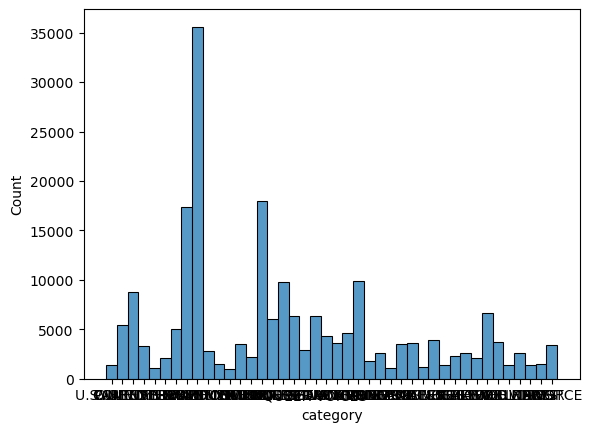

In [52]:
sns.histplot(reviews.category)
plt.show()

[Text(0, 0, 'POLITICS'),
 Text(1, 0, 'WELLNESS'),
 Text(2, 0, 'ENTERTAINMENT'),
 Text(3, 0, 'TRAVEL'),
 Text(4, 0, 'STYLE & BEAUTY'),
 Text(5, 0, 'PARENTING'),
 Text(6, 0, 'HEALTHY LIVING'),
 Text(7, 0, 'QUEER VOICES'),
 Text(8, 0, 'FOOD & DRINK'),
 Text(9, 0, 'BUSINESS'),
 Text(10, 0, 'COMEDY'),
 Text(11, 0, 'SPORTS'),
 Text(12, 0, 'BLACK VOICES'),
 Text(13, 0, 'HOME & LIVING'),
 Text(14, 0, 'PARENTS'),
 Text(15, 0, 'THE WORLDPOST'),
 Text(16, 0, 'WEDDINGS'),
 Text(17, 0, 'WOMEN'),
 Text(18, 0, 'CRIME'),
 Text(19, 0, 'IMPACT'),
 Text(20, 0, 'DIVORCE'),
 Text(21, 0, 'WORLD NEWS'),
 Text(22, 0, 'MEDIA'),
 Text(23, 0, 'WEIRD NEWS'),
 Text(24, 0, 'GREEN'),
 Text(25, 0, 'WORLDPOST'),
 Text(26, 0, 'RELIGION'),
 Text(27, 0, 'STYLE'),
 Text(28, 0, 'SCIENCE'),
 Text(29, 0, 'TECH'),
 Text(30, 0, 'TASTE'),
 Text(31, 0, 'MONEY'),
 Text(32, 0, 'ARTS'),
 Text(33, 0, 'ENVIRONMENT'),
 Text(34, 0, 'FIFTY'),
 Text(35, 0, 'GOOD NEWS'),
 Text(36, 0, 'U.S. NEWS'),
 Text(37, 0, 'ARTS & CULTURE'),
 Text(38,

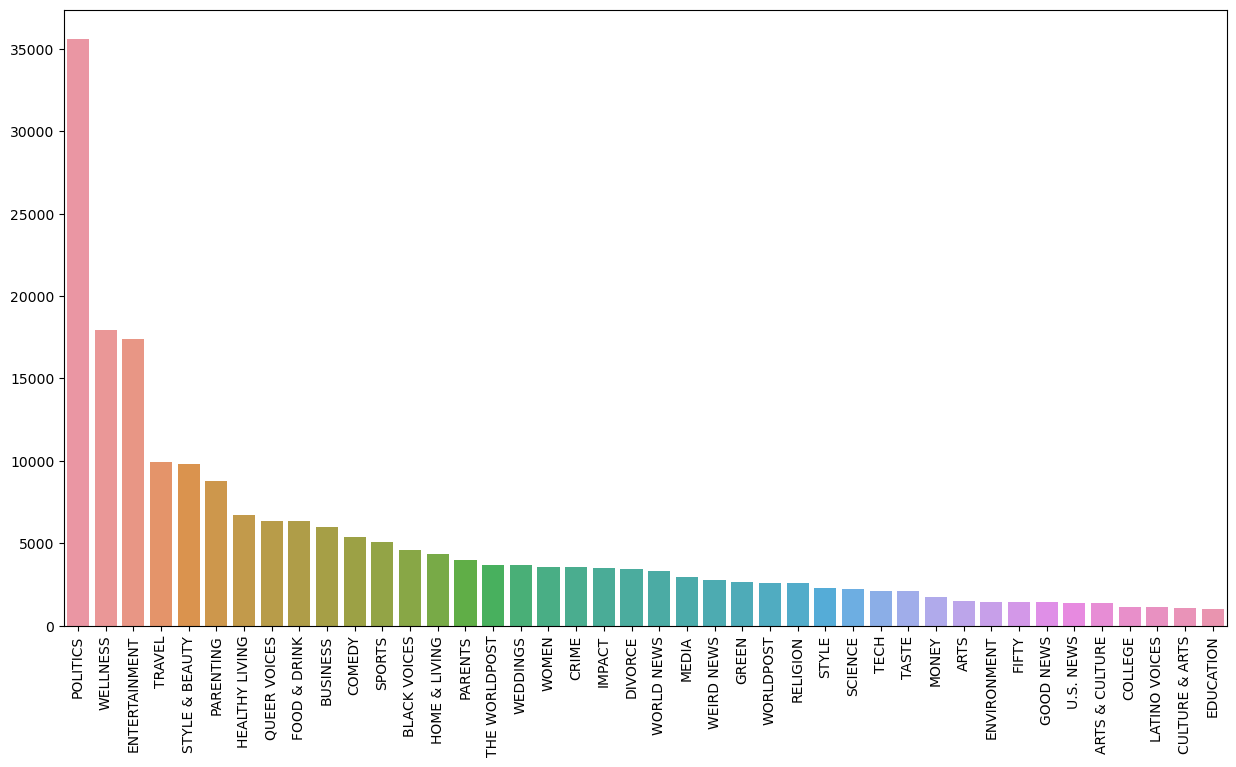

In [8]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=reviews["category"].value_counts().index, y=reviews["category"].value_counts().values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## - Grouping the categories
### Except for 'politics', which is twice as many articles as the second 'wellness', we will categorize the remaining 41 to 10. (Then, the total number of categories is 11.)


In [9]:
def grouping(dataset, lst, name):
    for category in reviews['category'].value_counts().index:
        if category in lst:
            dataset.loc[dataset['category'] == category, 'category'] = name
            
grouping(reviews, lst=['WELLNESS', 'HEALTHY LIVING', 'HOME & LIVING', 'STYLE & BEAUTY', 'STYLE'], name = 'LIFE & WELLNESS')
grouping(reviews, lst=['PARENTING', 'PARENTS', 'EDUCATION', 'COLLEGE'], name = 'PARENTING & EDUCATION')
grouping(reviews, lst=['SPORTS', 'ENTERTAINMENT', 'COMEDY','WEIRD NEWS', 'ARTS'], name='SPORTS & ENTERTAINMENT')
grouping(reviews, lst=['TRAVEL', 'ARTS & CULTURE', 'CULTURE & ARTS', 'FOOD & DRINK', 'TASTE'], name = 'TRAVEL & ART')
grouping(reviews, lst=['WOMEN','QUEER VOICES', 'LATINO VOICES', 'BLACK VOICES'] , name = 'EMPOWERED VOICES')
grouping(reviews, lst= ['BUSINESS', 'MONEY'] , name = 'BUSINESS & MONEY')
grouping(reviews, lst= ['THE WORLDPOST', 'WORLDPOST', 'WORLD NEWS'], name = 'WORLDNEWS')
#grouping(reviews, lst= ['ENVIRONMENT','GREEN'], name = 'ENVIRONMENT')
grouping(reviews, lst= ['TECH', 'SCIENCE', 'ENVIRONMENT','GREEN'], name = 'SCIENCE & ENVIRONMENT')
grouping(reviews, lst= ['FIFTY', 'IMPACT', 'GOOD NEWS','CRIME', 'U.S. NEWS'], name =  'GENERAL')
grouping(reviews, lst= ['WEDDINGS', 'DIVORCE', 'RELIGION','MEDIA'], name =  'MISC')

[Text(0, 0, 'LIFE & WELLNESS'),
 Text(1, 0, 'POLITICS'),
 Text(2, 0, 'SPORTS & ENTERTAINMENT'),
 Text(3, 0, 'TRAVEL & ART'),
 Text(4, 0, 'EMPOWERED VOICES'),
 Text(5, 0, 'PARENTING & EDUCATION'),
 Text(6, 0, 'MISC'),
 Text(7, 0, 'GENERAL'),
 Text(8, 0, 'WORLDNEWS'),
 Text(9, 0, 'SCIENCE & ENVIRONMENT'),
 Text(10, 0, 'BUSINESS & MONEY')]

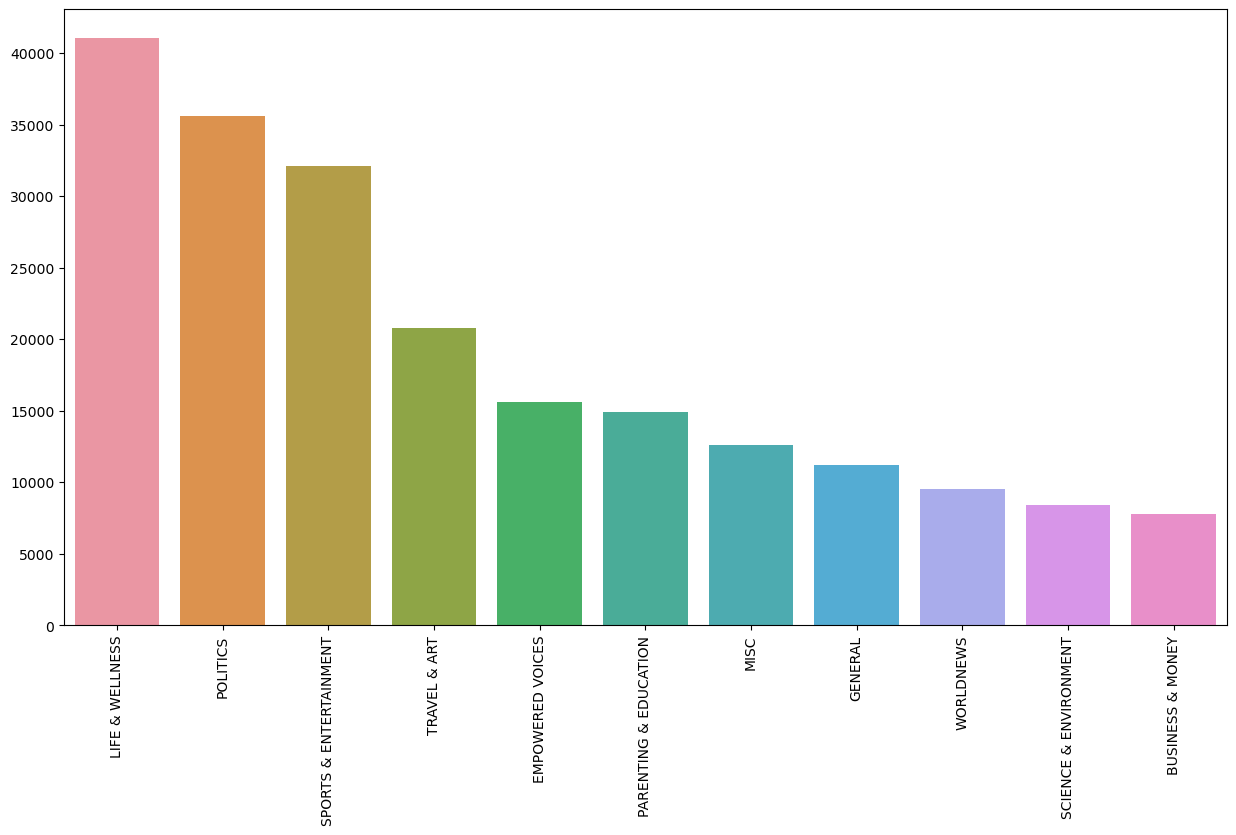

In [10]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=reviews["category"].value_counts().index, y=reviews["category"].value_counts().values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Finally remove 'MISC', 'GENERAL', 'WORLDNEWS' for reducing the total number of categories as 8, because after clustering, in order to evaluate accuracy, which is calculated by comparing real category and permuted clustered group, so that the calculation  of permutation does take too much time in case the number of categories is over 8. 

In [56]:
min(reviews['category'].value_counts())

7748

In [11]:
reviews2 = reviews.query('category !=["MISC", "GENERAL", "WORLDNEWS"]')

[Text(0, 0, 'LIFE & WELLNESS'),
 Text(1, 0, 'POLITICS'),
 Text(2, 0, 'SPORTS & ENTERTAINMENT'),
 Text(3, 0, 'TRAVEL & ART'),
 Text(4, 0, 'EMPOWERED VOICES'),
 Text(5, 0, 'PARENTING & EDUCATION'),
 Text(6, 0, 'SCIENCE & ENVIRONMENT'),
 Text(7, 0, 'BUSINESS & MONEY')]

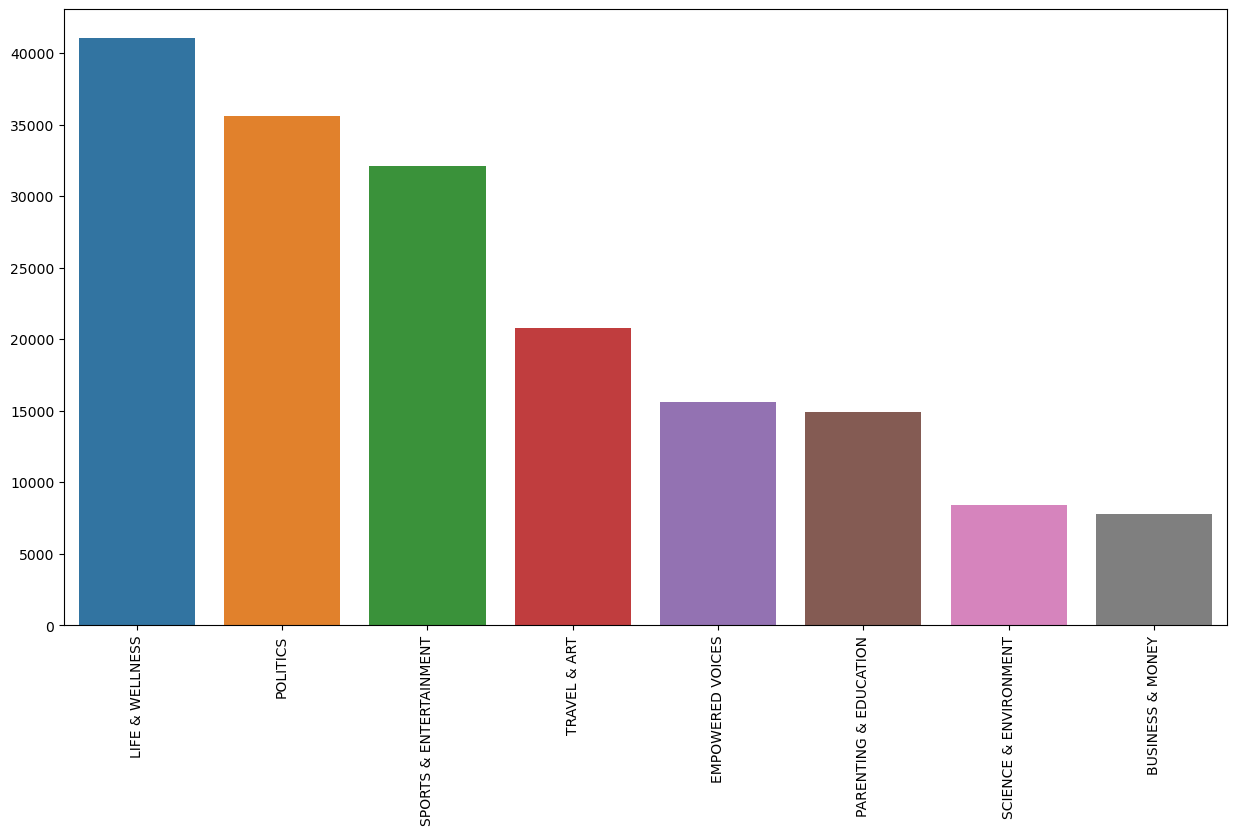

In [12]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=reviews2["category"].value_counts().index, y=reviews2["category"].value_counts().values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## - Balancing data

In [13]:
reviews2['category'].unique()

array(['SPORTS & ENTERTAINMENT', 'PARENTING & EDUCATION', 'TRAVEL & ART',
       'SCIENCE & ENVIRONMENT', 'POLITICS', 'LIFE & WELLNESS',
       'BUSINESS & MONEY', 'EMPOWERED VOICES'], dtype=object)

In [14]:
review_short = pd.concat(reviews2[reviews2['category']==i].sample(n=7748, replace=False, random_state = 39) for i in list(reviews2['category'].unique()))
#pd.concat([reviews[reviews['category']== i].sample(n=5000, replace=False) for i in ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL','STYLE & BEAUTY', 'HEALTHY LIVING', 'FOOD & DRINK','BUSINESS']])                          

In [15]:
review_short['category'].nunique()

8

[Text(0, 0, 'SPORTS & ENTERTAINMENT'),
 Text(1, 0, 'PARENTING & EDUCATION'),
 Text(2, 0, 'TRAVEL & ART'),
 Text(3, 0, 'SCIENCE & ENVIRONMENT'),
 Text(4, 0, 'POLITICS'),
 Text(5, 0, 'LIFE & WELLNESS'),
 Text(6, 0, 'BUSINESS & MONEY'),
 Text(7, 0, 'EMPOWERED VOICES')]

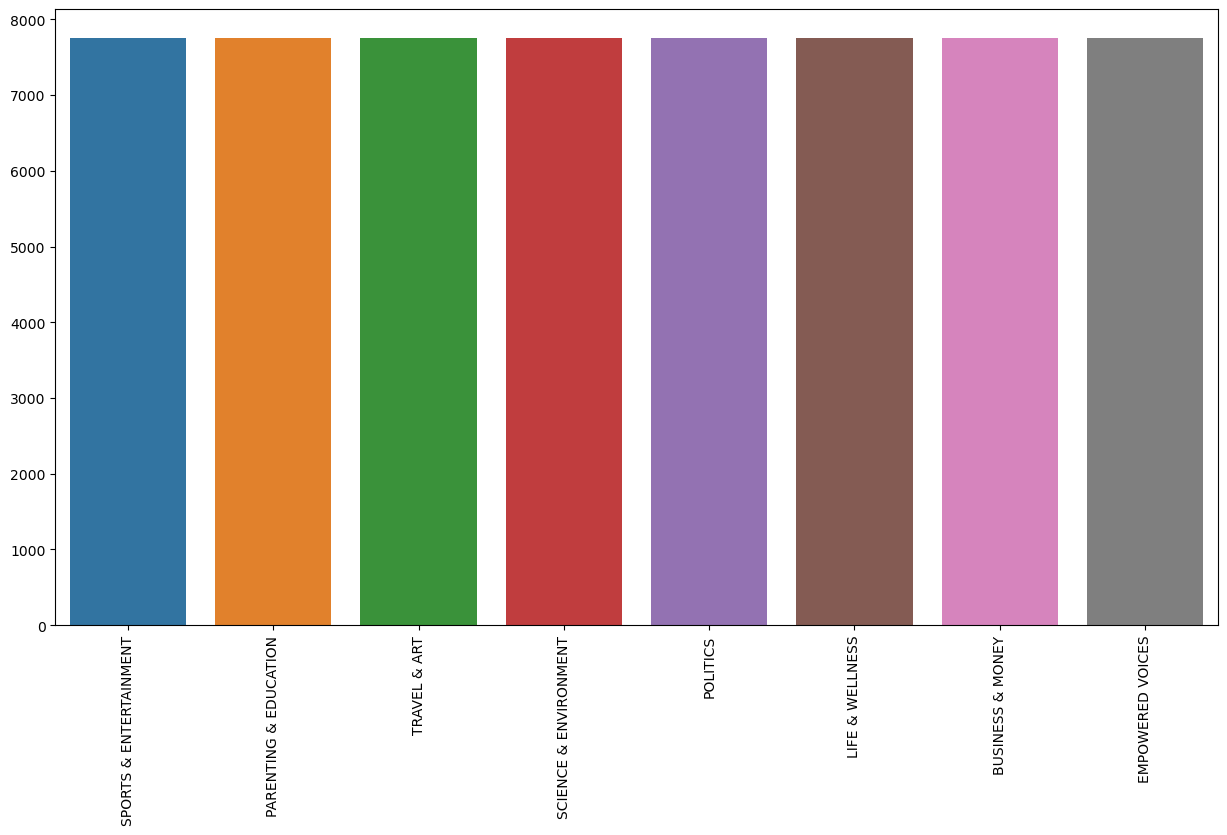

In [16]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=review_short["category"].value_counts().index, y=review_short["category"].value_counts().values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

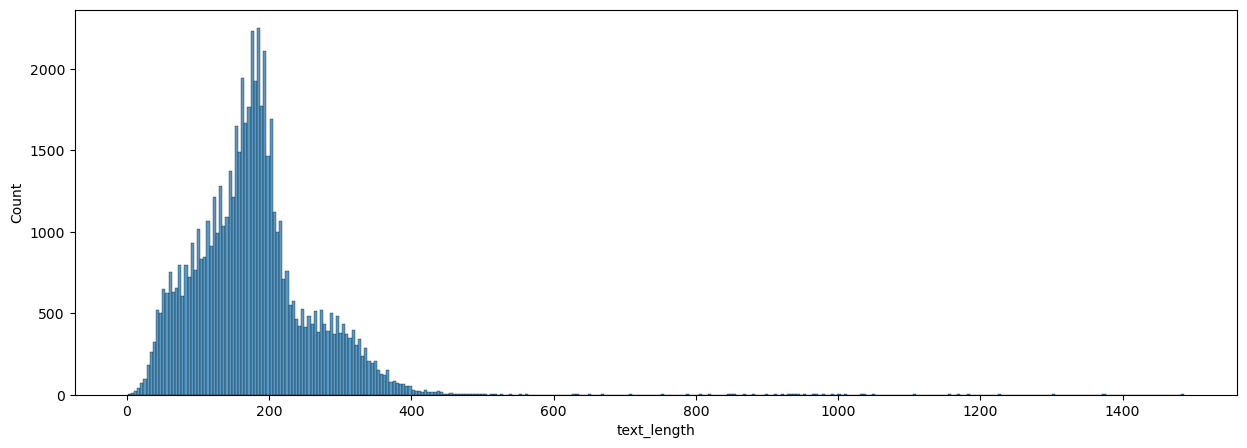

In [63]:
review_short['text_length'] = review_short.combined_text.apply(lambda x: len(x))
fig, ax = plt.subplots(figsize=(15,5))
sns.histplot(review_short.text_length)
plt.show()


## (1) Cleaning Text
### We will remove puctuation 'stop words' and make case normalization.

In [17]:
## remove punctuation & Case normalization

def clean_text(df):
    stop_words = stopwords.words('english')
    df['no_punctuation'] = df['combined_text'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
    df['no_number'] = df['no_punctuation'].apply(lambda row: re.sub(r'[0-9]+', '', row))
    df['clean_text'] = df['no_number'].apply(lambda x : ' '.join([i for i in x.split() if i.lower() not in (stop_words)]))
    return

clean_text(review_short)
review_short

link  \
92311   https://www.huffingtonpost.com/entry/pet-torto...   
52135   https://www.huffingtonpost.com/entry/paris-bat...   
205523  https://www.huffingtonpost.com/entry/snl-jonah...   
87551   https://www.huffingtonpost.com/entry/dog-sends...   
121234  https://www.huffingtonpost.com/entry/shocked-a...   
...                                                   ...   
195851  https://www.huffingtonpost.com/entry/illinois-...   
4075    https://www.huffpost.com/entry/the-20-funniest...   
135443  https://www.huffingtonpost.com/entry/bisexual-...   
71175   https://www.huffingtonpost.comhttp://nymag.com...   
91610   https://www.huffingtonpost.comhttp://www.rooki...   

                                                 headline  \
92311   Pet Tortoise Crosses The Road, Spends Whopping...   
52135   Sting To Perform At Paris Venue Closed By Dead...   
205523  'SNL': Jonah Hill Talks Oscars, 'Moneyball' In...   
87551      Dog Shifts Truck Into Gear, Sends It Into Lake   
121234  Shocked and Surprised: I Will Deeply Miss Joan...   
...                                                   ...   
195851  Illinois Lesbian Couple Denied Use Of Receptio...   
4075    The 20 Funniest Tweets From Women This Week (S...   
135443                   Bisexual Culture Is No 'Fiction'   
71175           The Truth About Men Who Like Coercive Sex   
91610                              How To Accept Kindness   

                      category  \
92311   SPORTS & ENTERTAINMENT   
52135   SPORTS & ENTERTAINMENT   
205523  SPORTS & ENTERTAINMENT   
87551   SPORTS & ENTERTAINMENT   
121234  SPORTS & ENTERTAINMENT   
...                        ...   
195851        EMPOWERED VOICES   
4075          EMPOWERED VOICES   
135443        EMPOWERED VOICES   
71175         EMPOWERED VOICES   
91610         EMPOWERED VOICES   

                                        short_description  \
92311   It only took one retweet to reunited the poor ...   
52135   "We hope to respect the memory as well as the ...   
205523  Jonah Hill may have been nominated for an Acad...   
87551                   Don't worry, the pup was rescued!   
121234  Joan Rivers was the ultimate survivor who snat...   
...                                                   ...   
195851  An Illinois-based lesbian couple is searching ...   
4075    "That Hakuna Matata sequence where Simba grows...   
135443  Even if these writers concede -- with hesitati...   
71175   What sort of bedroom behavior would make you i...   
91610                           Just take the compliment.   

                                                  authors       date  \
92311                                                     2015-08-06   
52135                                                     2016-11-04   
205523                                                    2012-03-11   
87551                                                     2015-09-29   
121234  SaraKay Smullens, ContributorFamily therapist ... 2014-09-08   
...                                                   ...        ...   
195851                                                    2012-06-23   
4075                                     Caroline Bologna 2020-09-18   
135443   Alex Berg, Contributor\nProducer, HuffPost Video 2014-03-29   
71175                                                     2016-04-01   
91610                                                     2015-08-14   

                                            combined_text  \
92311   Pet Tortoise Crosses The Road, Spends Whopping...   
52135   Sting To Perform At Paris Venue Closed By Dead...   
205523  'SNL': Jonah Hill Talks Oscars, 'Moneyball' In...   
87551   Dog Shifts Truck Into Gear, Sends It Into Lake...   
121234  Shocked and Surprised: I Will Deeply Miss Joan...   
...                                                   ...   
195851  Illinois Lesbian Couple Denied Use Of Receptio...   
4075    The 20 Funniest Tweets From Women This Week (S...   
135443  Bisexual Culture Is No 

In [18]:
review_short = review_short.reset_index(drop=True)
review_short['clean_text'][0]

'Pet Tortoise Crosses Road Spends Whopping HalfMile Lam took one retweet reunited poor guy family'

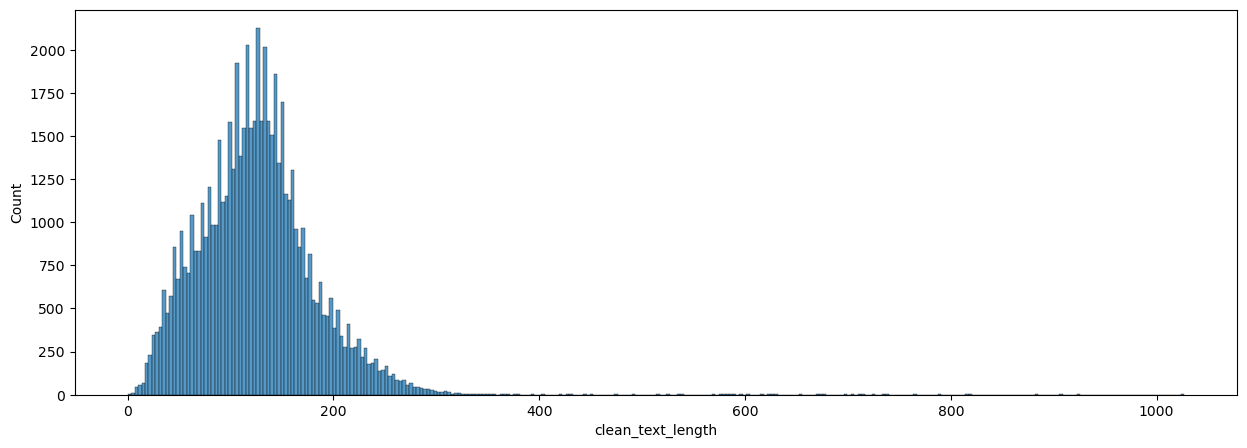

In [19]:
review_short["clean_text_length"] = review_short.clean_text.apply(lambda x: len(x))
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(review_short.clean_text_length)
plt.show()

## (2) Removing outliners

In [20]:
len(review_short[review_short["clean_text_length"]>330])

93

In [21]:
review_short = review_short[review_short['clean_text_length'] < 330]
len(review_short)

61887

# 3. Model building

In [22]:
review_short_df = review_short.copy()

In [70]:
list(review_short.category.unique())

['SPORTS & ENTERTAINMENT',
 'PARENTING & EDUCATION',
 'TRAVEL & ART',
 'SCIENCE & ENVIRONMENT',
 'POLITICS',
 'LIFE & WELLNESS',
 'BUSINESS & MONEY',
 'EMPOWERED VOICES']

In [23]:
len(review_short_df)

61887

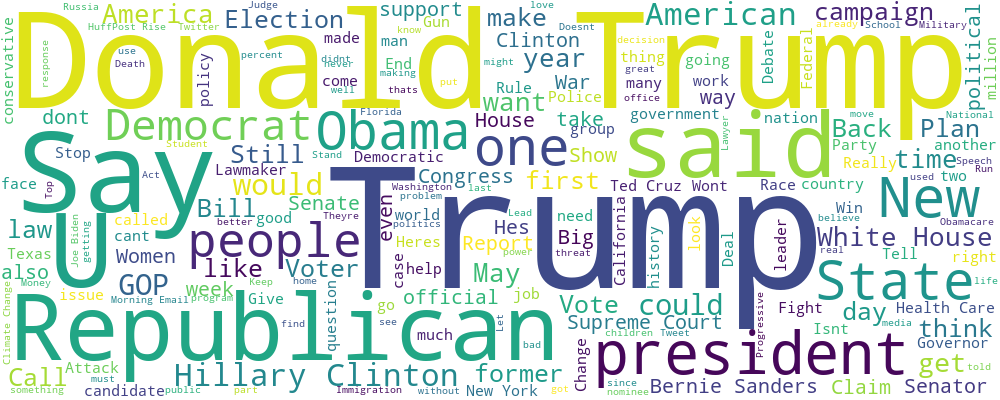

In [24]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', width = 1000, height=400, stopwords = [])
wc.generate(" ".join(t for t in review_short_df[review_short_df.category == 'POLITICS'].clean_text)).to_image()

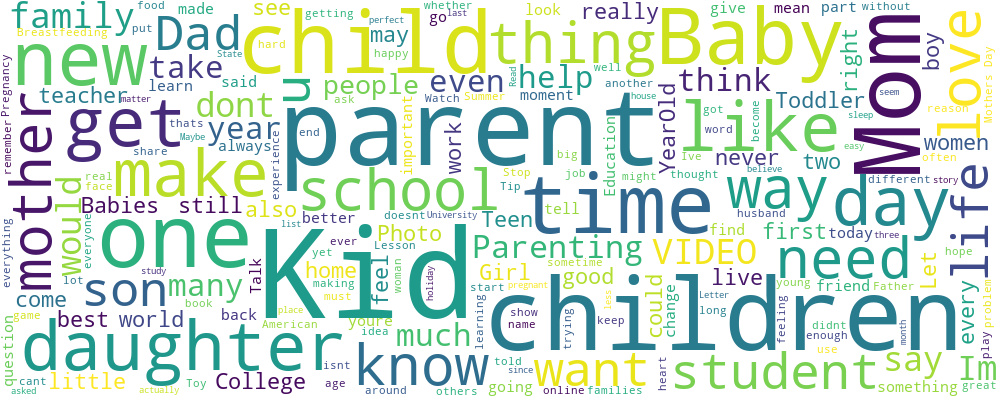

In [25]:
wc = WordCloud(background_color='white', width = 1000, height=400, stopwords = [])
wc.generate(" ".join(t for t in review_short_df[review_short_df.category == 'PARENTING & EDUCATION'].clean_text)).to_image()

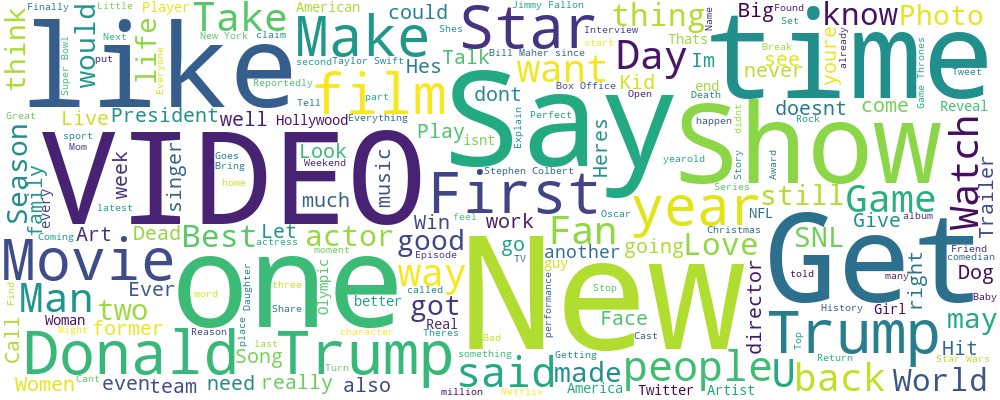

In [26]:
wc = WordCloud(background_color='white', width = 1000, height=400, stopwords = [])
wc.generate(" ".join(t for t in review_short_df[review_short_df.category == 'SPORTS & ENTERTAINMENT'].clean_text)).to_image()

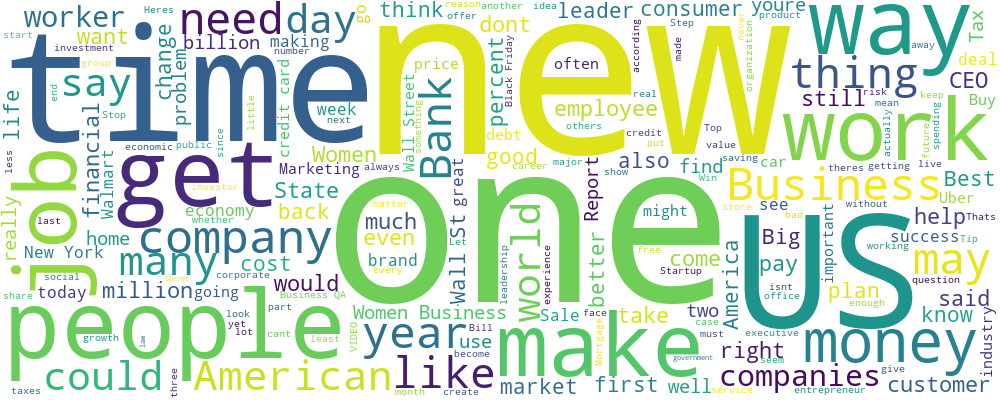

In [28]:
wc = WordCloud(background_color='white', width = 1000, height=400, stopwords = [])
wc.generate(" ".join(t for t in review_short_df[review_short_df.category == 'BUSINESS & MONEY'].clean_text)).to_image()

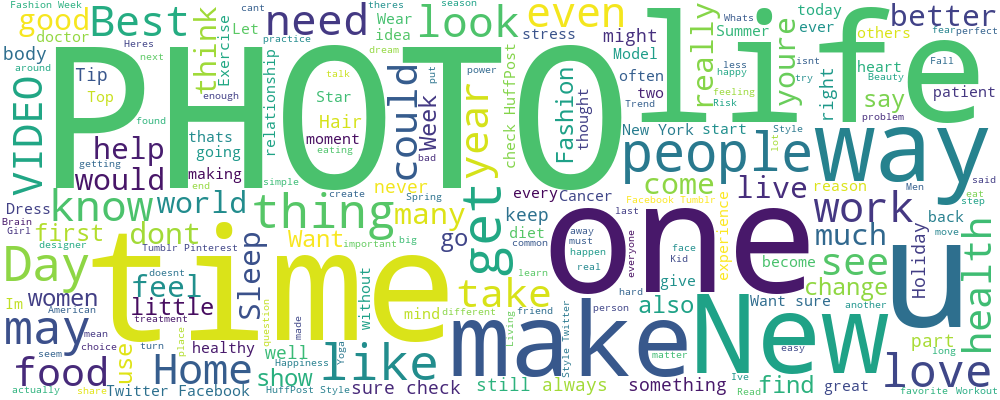

In [27]:
wc = WordCloud(background_color='white', width = 1000, height=400, stopwords = [])
wc.generate(" ".join(t for t in review_short_df[review_short_df.category == 'LIFE & WELLNESS'].clean_text)).to_image()

## For evaluation, 'label_premute' function is created; to compare newly created 8 clusters with original 8 categories.

In [72]:
def label_permute(ytdf,yp):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    y_true = np.array(ytdf).reshape(-1)
    perms = itertools.permutations([i for i in range(8)])    #create permutation list
    best_labels, best_acc = None, 0
    
    labels = list(review_short.category.unique())
    for perm in perms:
        p_label_map = {label: int_label for label, int_label in zip(labels, perm)}
        p_label = np.array([p_label_map[label] for label in y_true])
        acc = np.mean(p_label == yp)
        if acc > best_acc:
            best_labels = {num: l for num, l in zip(perm, labels)}
            best_acc = acc
    return best_labels, best_acc

## (1) Vectorizing words
## In order to treat words as numbers, TFIDF (Term Frequency - Inverse Document Frequency) is used. 
## This method is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. 
## The TFIDF value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

### (i) ngram = 1 for vectorizer hyperparameter (default)

In [80]:
#create vectorizer default min_df = 1, max_df=1

tfidvec = TfidfVectorizer(sublinear_tf = True,
                          norm = 'l2',
                          stop_words = 'english')

tfidvec_train = tfidvec.fit_transform(review_short_df['clean_text'])
tfidvec_train.shape

(61887, 62371)

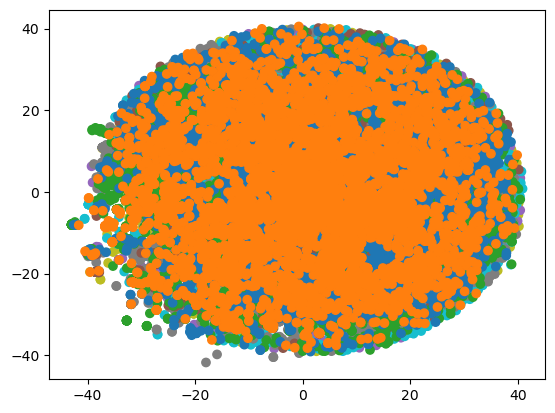

In [96]:
tsne = TSNE(n_components=2, init = 'random', random_state=39)
tsne_train = tsne.fit_transform(tfidvec_train)

plt.scatter(tsne_train[:, 0], tsne_train[:, 1], c=review_short['category'].astype('category').cat.codes, cmap='tab10')
plt.show()

### (ii) ngam = 2

In [81]:
#create vectorizer default * ngram = (1,2)

tfidvec_ng2 = TfidfVectorizer(sublinear_tf = True,
                          norm = 'l2',
                          ngram_range=(1,2),
                          stop_words = 'english')

tfidvec_train_ng2 = tfidvec_ng2.fit_transform(review_short_df['clean_text'])
tfidvec_train_ng2.shape

(61887, 778919)

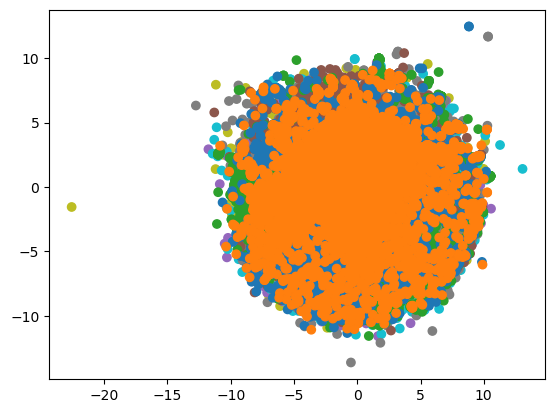

In [98]:
tsne = TSNE(n_components=2, init = 'random', random_state=39)
tsne_train_ng2 = tsne.fit_transform(tfidvec_train_ng2)

plt.scatter(tsne_train_ng2[:, 0], tsne_train_ng2[:, 1], c=review_short['category'].astype('category').cat.codes, cmap='tab10')
plt.show()

### (iii) ngram = 3

In [82]:
#create vectorizer default * ngram = (1,3)

tfidvec_ng3 = TfidfVectorizer(sublinear_tf = True,
                          norm = 'l2',
                          ngram_range=(1,3),
                          stop_words = 'english')

tfidvec_train_ng3 = tfidvec_ng3.fit_transform(review_short_df['clean_text'])
tfidvec_train_ng3.shape

(61887, 1618071)

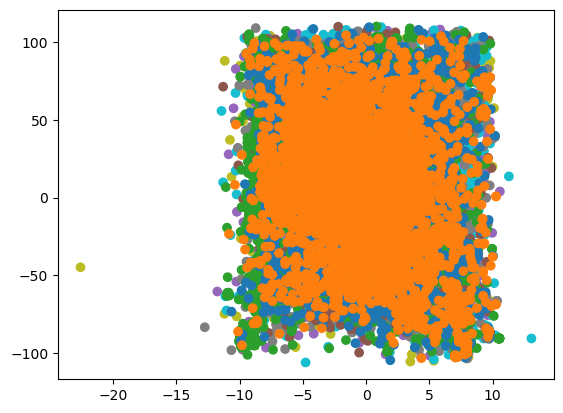

In [100]:
tsne = TSNE(n_components=2, init = 'random', random_state=39)
tsne_train_ng3 = tsne.fit_transform(tfidvec_train_ng3)

plt.scatter(tsne_train_ng2[:, 0], tsne_train_ng3[:, 1], c=review_short['category'].astype('category').cat.codes, cmap='tab10')
plt.show()

## (2) Model setting
## We will use Non-negative Matrix Factorization for clustering. 
## (i) Initial setting
### Firstly based on the ngam 1 vectorized data, the default setting of NMF is used.
### Accuracy is 0.2707.

In [83]:
#create model defalut parameter of NMF

paraNMF = {'n_components':8}

nmf_model = NMF(**paraNMF, init = 'random', random_state=39, max_iter=1000)


nmf_model.fit(tfidvec_train)

pred_train = np.array([np.argmax(i) for i in nmf_model.transform(tfidvec_train)])
label_order, accuracy = label_permute(review_short_df.category, pred_train )

print('accuracy=', accuracy)

accuracy= 0.27070305556902097


### Under the same vectorized data, we will change 'solver' and 'beta_loss' of the NMF.
### As accuracy is 0.2930, it would suggest that this hyperparameter setting is better than the default setting of NMF.

In [84]:
#change hyperparameter

nmf_model = NMF(**paraNMF, init = 'random', random_state=39, solver='mu', beta_loss='kullback-leibler', max_iter=1000)


nmf_model.fit(tfidvec_train)

pred_train = np.array([np.argmax(i) for i in nmf_model.transform(tfidvec_train)])
label_order, accuracy = label_permute(review_short_df.category, pred_train )

print('accuracy=', accuracy)

accuracy= 0.29296944430979044


### Under the better setting of NMF, ngram 2 vectorized data is used.
### As accuracy is 0.1317, the increase of ngam would not contribute accuracy.

In [85]:
#change hyperparameter ngram = (1,2)

nmf_model = NMF(**paraNMF, init = 'random', random_state=39, solver='mu', beta_loss='kullback-leibler', max_iter=1000)


nmf_model.fit(tfidvec_train_ng2)

pred_train = np.array([np.argmax(i) for i in nmf_model.transform(tfidvec_train_ng2)])
label_order, accuracy = label_permute(review_short_df.category, pred_train )

print('accuracy=', accuracy)

accuracy= 0.13170779000436278


## (ii) Hyperparamter tuning

## - Tuning hyperparameter of tfidfvectorizer

### (1) min_df = 2, max_df=1

In [86]:
#create vectorizer default min_df = 2, max_df=1

paraTfidf = {'max_df':1.0, 'min_df':2}

tfidvec2 = TfidfVectorizer(sublinear_tf = True,
                          **paraTfidf,
                          norm = 'l2',
                          stop_words = 'english')

tfidvec_train2 = tfidvec2.fit_transform(review_short_df['clean_text'])
tfidvec_train2.shape

(61887, 32694)

In [87]:
#change hyperparameter

nmf_model = NMF(**paraNMF, init = 'random', random_state=39, solver='mu', beta_loss='kullback-leibler', max_iter=1000)


nmf_model.fit(tfidvec_train2)

pred_train = np.array([np.argmax(i) for i in nmf_model.transform(tfidvec_train2)])
label_order, accuracy = label_permute(review_short_df.category, pred_train )

print('accuracy=', accuracy)

accuracy= 0.3688496776382762


### (2) min_df = 3, max_df = 1 

In [88]:
#create vectorizer default min_df = 3, max_df=1

paraTfidf = {'max_df':1.0, 'min_df':3}


tfidvec3 = TfidfVectorizer(sublinear_tf = True,
                           **paraTfidf,
                          norm = 'l2',
                          stop_words = 'english')

tfidvec_train3 = tfidvec3.fit_transform(review_short_df['clean_text'])
tfidvec_train3.shape

(61887, 24784)

In [89]:
#change hyperparameter
paraNMF = {'n_components':8}
nmf_model = NMF(**paraNMF, init = 'random', random_state=39,  solver='mu', beta_loss='kullback-leibler',max_iter=1000)


nmf_model.fit(tfidvec_train3)

pred_train = np.array([np.argmax(i) for i in nmf_model.transform(tfidvec_train3)])
label_order, accuracy = label_permute(review_short_df.category, pred_train )

print('accuracy=', accuracy)

accuracy= 0.30129106274338713


### min_df = 2, max_df = 1 -> # of iteration increases

In [90]:
## # of iterations -> 10000

nmf_model = NMF(**paraNMF, init = 'random', random_state=39, max_iter=10000)


nmf_model.fit(tfidvec_train2)

pred_train = np.array([np.argmax(i) for i in nmf_model.transform(tfidvec_train2)])
label_order, accuracy = label_permute(review_short_df.category, pred_train )

print('accuracy=', accuracy)

accuracy= 0.2414400439510721


### min_df = 2, max_df = 1, # of iteration = 1000 would be the best

In [99]:
nmf_model = NMF(**paraNMF, init = 'random', random_state=39, solver='mu', beta_loss='kullback-leibler', max_iter=1000)

nmf_model.fit(tfidvec_train2)

pred_train = np.array([np.argmax(i) for i in nmf_model.transform(tfidvec_train2)])
label_order, accuracy = label_permute(review_short_df.category, pred_train )

print('accuracy=', accuracy)

accuracy= 0.3688496776382762


EMPOWERED VOICES


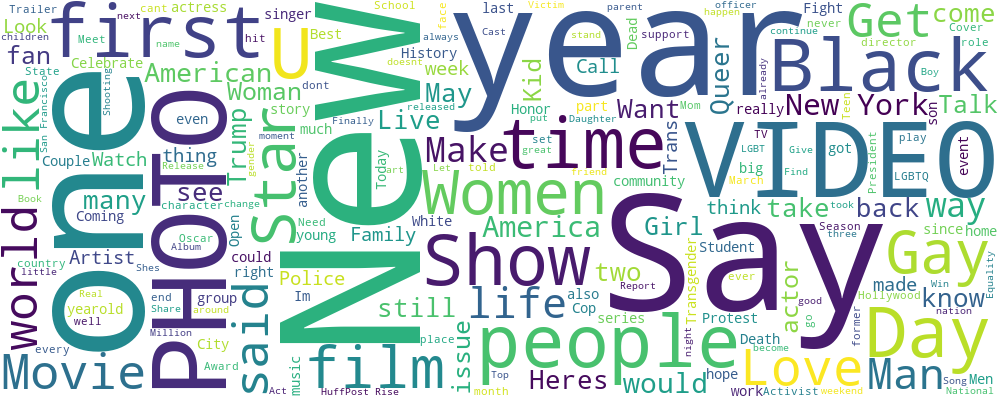

In [128]:
j=0
index1 = [i for i, x in enumerate(pred_train) if x == j]
temp1 = [review_short_df.iloc[i,].clean_text for i in index1]
print(label_order[j])
wc.generate(" ".join(t for t in temp1)).to_image()

SCIENCE & ENVIRONMENT


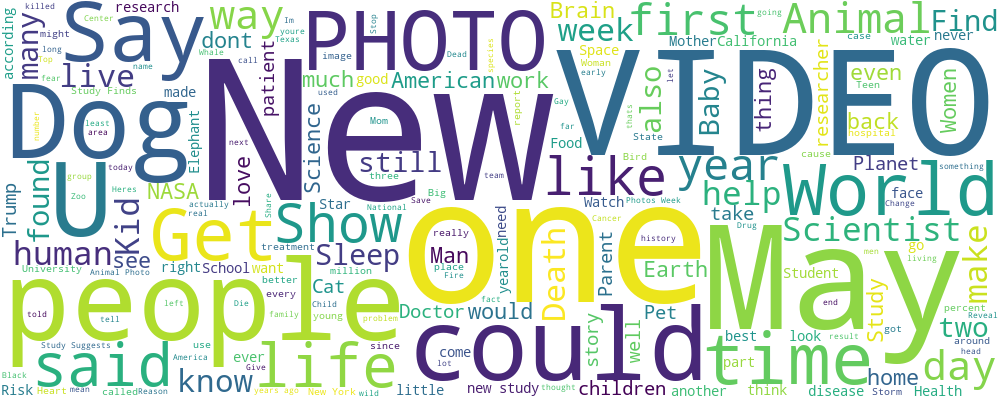

In [129]:
j=1
index1 = [i for i, x in enumerate(pred_train) if x == j]
temp1 = [review_short_df.iloc[i,].clean_text for i in index1]
print(label_order[j])
wc.generate(" ".join(t for t in temp1)).to_image()

PARENTING & EDUCATION


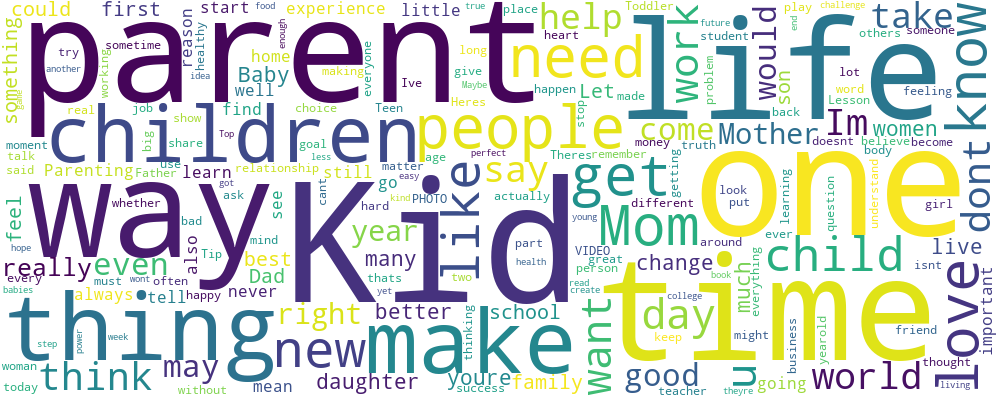

In [130]:
j=2
index1 = [i for i, x in enumerate(pred_train) if x == j]
temp1 = [review_short_df.iloc[i,].clean_text for i in index1]
print(label_order[j])
wc.generate(" ".join(t for t in temp1)).to_image()

POLITICS


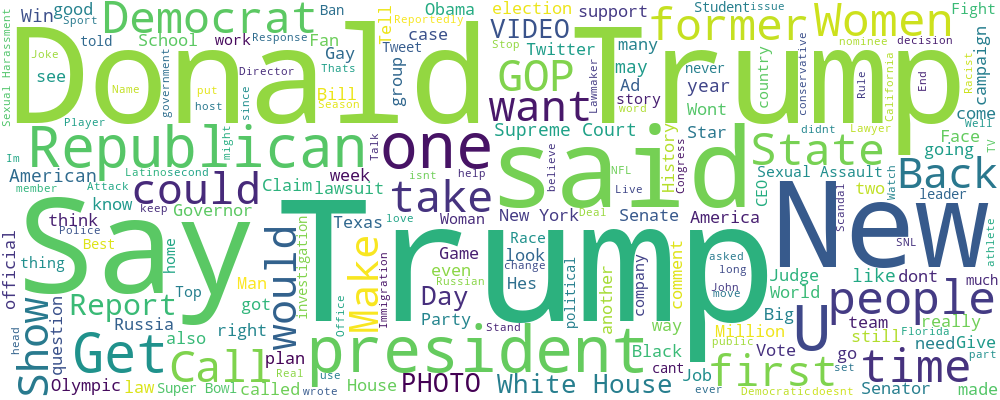

In [131]:
j=3
index1 = [i for i, x in enumerate(pred_train) if x == j]
temp1 = [review_short_df.iloc[i,].clean_text for i in index1]
print(label_order[j])
wc.generate(" ".join(t for t in temp1)).to_image()

TRAVEL & ART


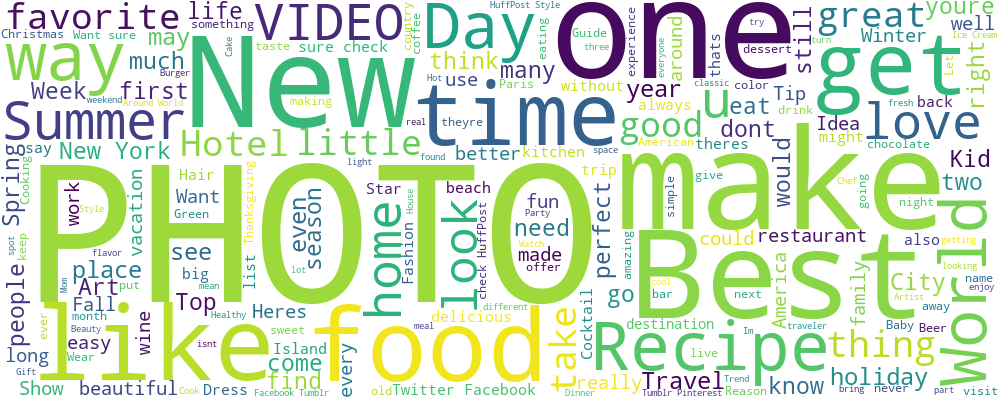

In [132]:
j=4
index1 = [i for i, x in enumerate(pred_train) if x == j]
temp1 = [review_short_df.iloc[i,].clean_text for i in index1]
print(label_order[j])
wc.generate(" ".join(t for t in temp1)).to_image()

BUSINESS & MONEY


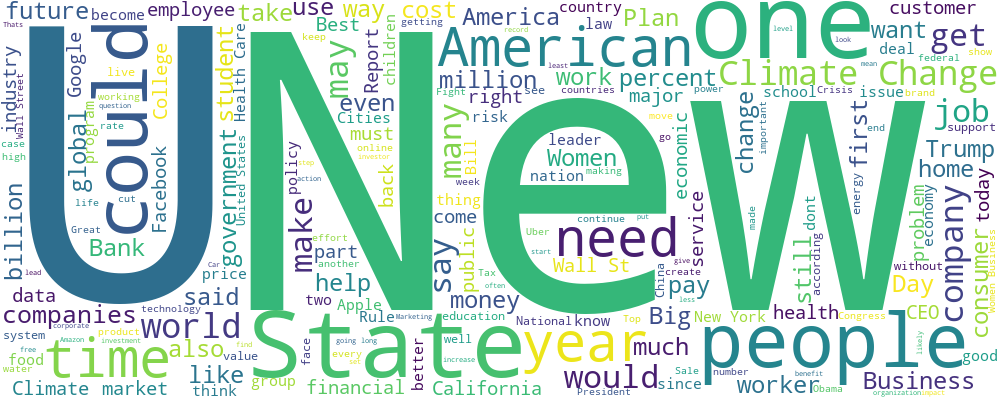

In [133]:
j=5
index1 = [i for i, x in enumerate(pred_train) if x == j]
temp1 = [review_short_df.iloc[i,].clean_text for i in index1]
print(label_order[j])
wc.generate(" ".join(t for t in temp1)).to_image()

SPORTS & ENTERTAINMENT


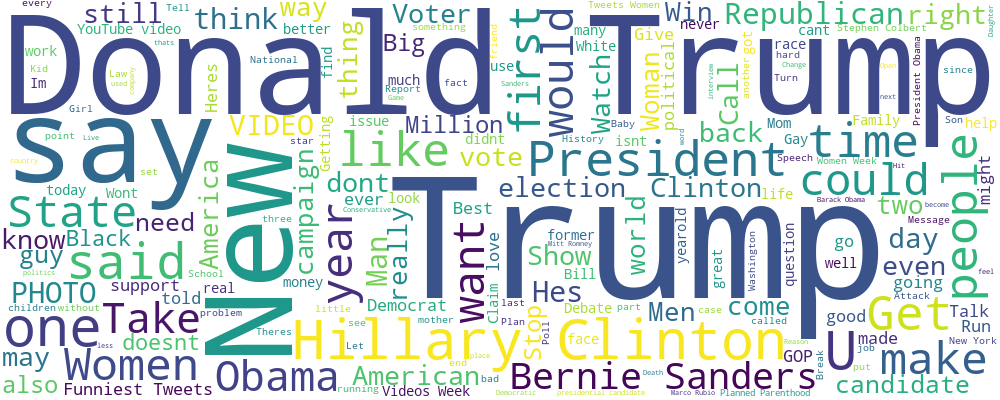

In [134]:
j=6
index1 = [i for i, x in enumerate(pred_train) if x == j]
temp1 = [review_short_df.iloc[i,].clean_text for i in index1]
print(label_order[j])
wc.generate(" ".join(t for t in temp1)).to_image()

LIFE & WELLNESS


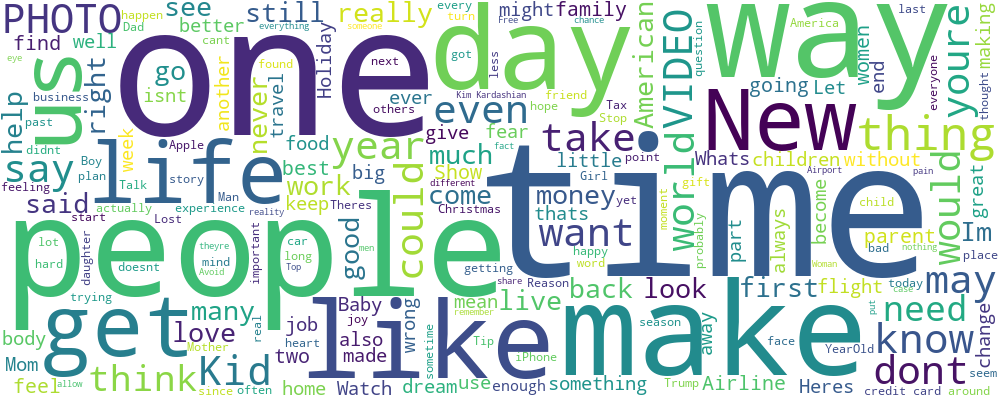

In [135]:
j=7
index1 = [i for i, x in enumerate(pred_train) if x == j]
temp1 = [review_short_df.iloc[i,].clean_text for i in index1]
print(label_order[j])
wc.generate(" ".join(t for t in temp1)).to_image()

In [136]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i, r in df.iterrows():
        print(label_order[i])
        print(', '.join([labels[t] for t in np.argsort(r)[-n_terms:]]))



get_top_keywords(tfidvec_train2, pred_train, tfidvec2.get_feature_names_out(),10)

EMPOWERED VOICES
police, video, lgbt, years, day, film, people, gay, new, black
SCIENCE & ENVIRONMENT
shows, dog, animal, life, week, scientists, people, video, new, study
PARENTING & EDUCATION
people, day, things, know, children, time, parents, life, dont, kids
POLITICS
court, house, gop, new, said, says, president, trumps, donald, trump
TRAVEL & ART
time, summer, make, food, recipes, like, day, new, best, photos
BUSINESS & MONEY
women, wall, people, health, companies, states, change, business, new, climate
SPORTS & ENTERTAINMENT
obama, tweets, president, sanders, women, hillary, week, donald, clinton, trump
LIFE & WELLNESS
things, know, make, dont, day, new, life, people, like, time


In [137]:
#create vectorizer default min_df = 3, max_df=1 ngam=(1,3)

paraTfidf = {'max_df':1.0, 'min_df':3}

tfidvec_ng3_1 = TfidfVectorizer(sublinear_tf = True,
                              **paraTfidf,
                            norm = 'l2',
                          ngram_range=(1,3),
                          stop_words = 'english')

tfidvec_train_ng3_1 = tfidvec_ng3_1.fit_transform(review_short_df['clean_text'])
tfidvec_train_ng3_1.shape


(61887, 57539)

In [138]:
#change hyperparameter

nmf_model = NMF(**paraNMF, init = 'random', random_state=39, solver='mu', beta_loss='kullback-leibler', max_iter=1000)


nmf_model.fit(tfidvec_train_ng3_1)

pred_train = np.array([np.argmax(i) for i in nmf_model.transform(tfidvec_train_ng3_1)])
label_order, accuracy = label_permute(review_short_df.category, pred_train )

print('accuracy=', accuracy)

accuracy= 0.3091440851875192


In [139]:

get_top_keywords(tfidvec_train_ng3_1, pred_train, tfidvec_ng3_1.get_feature_names_out(),10)

SCIENCE & ENVIRONMENT
year, summer, years, time, world, travel, day, best, new, photos
BUSINESS & MONEY
people, money, time, big, companies, tax, climate change, new, change, climate
LIFE & WELLNESS
check, york, new york, fashion, look, photo, style, video, new, photos
TRAVEL & ART
time, best, want, recipes, dont, love, make, know, day, like
PARENTING & EDUCATION
need, school, make, people, time, new, life, children, parents, kids
POLITICS
black, police, new, says, said, president, donald trump, trumps, donald, trump
SPORTS & ENTERTAINMENT
life, black, video, time, movie, world, star, film, gay, new
EMPOWERED VOICES
time, care, trump, americans, week, new, people, health, business, women


### (3) min_df = 4, max_df = 1

In [140]:
#create vectorizer default min_df = 3, max_df=1

paraTfidf = {'max_df':1.0, 'min_df':4}


tfidvec4 = TfidfVectorizer(sublinear_tf = True,
                           **paraTfidf,
                          norm = 'l2',
                          stop_words = 'english')

tfidvec_train4 = tfidvec4.fit_transform(review_short_df['clean_text'])
tfidvec_train4.shape

(61887, 20623)

In [141]:
#change hyperparameter

nmf_model = NMF(**paraNMF, init = 'random', random_state=39, solver='mu', beta_loss='kullback-leibler',  max_iter=1000)


nmf_model.fit(tfidvec_train4)

pred_train = np.array([np.argmax(i) for i in nmf_model.transform(tfidvec_train4)])
label_order, accuracy = label_permute(review_short_df.category, pred_train )

print('accuracy=', accuracy)

accuracy= 0.35655307253542745


### tune l1_ratio

In [142]:
#change hyperparameter

paraNMF = {'n_components':8, 'l1_ratio':0.25}

nmf_model = NMF(**paraNMF, init = 'random', random_state=39, solver='mu', beta_loss='kullback-leibler', max_iter=1000)


nmf_model.fit(tfidvec_train3)

pred_train = np.array([np.argmax(i) for i in nmf_model.transform(tfidvec_train3)])
label_order, accuracy = label_permute(review_short_df.category, pred_train )

print('accuracy=', accuracy)

accuracy= 0.30129106274338713


In [143]:
#change hyperparameter

paraNMF = {'n_components':8, 'l1_ratio':0.5}

nmf_model = NMF(**paraNMF, init = 'random', random_state=39, solver='mu', beta_loss='kullback-leibler', max_iter=1000)


nmf_model.fit(tfidvec_train3)

pred_train = np.array([np.argmax(i) for i in nmf_model.transform(tfidvec_train3)])
label_order, accuracy = label_permute(review_short_df.category, pred_train )

print('accuracy=', accuracy)

accuracy= 0.30129106274338713


## (3) MiniBatchkmeans
### min_df = 2, max_df = 1

In [144]:
tfidvec2.get_feature_names_out()[700:800]

array(['amendment', 'amendments', 'amends', 'amenities', 'america',
       'american', 'americana', 'americanmade', 'americans', 'americas',
       'amfar', 'amid', 'amidst', 'amish', 'amiss', 'ammon', 'ammunition',
       'amnesia', 'amnesty', 'amoeba', 'amok', 'amounts', 'amp', 'ample',
       'amplified', 'amplify', 'amplifying', 'amps', 'amputee',
       'amsterdam', 'amsterdams', 'amtrak', 'amused', 'amusement',
       'amusing', 'amy', 'ana', 'anaheim', 'anais', 'anal', 'analog',
       'analogy', 'analyses', 'analysis', 'analyst', 'analysts',
       'analytica', 'analytical', 'analytics', 'analyze', 'analyzed',
       'analyzes', 'analyzing', 'anarchy', 'anastasia', 'anatomy',
       'ancestor', 'ancestors', 'ancestry', 'anchor', 'anchorage',
       'anchorman', 'anchors', 'anchovies', 'ancient', 'andersen',
       'anderson', 'andersons', 'andes', 'andi', 'andie', 'andor',
       'andre', 'andrea', 'andrew', 'andrews', 'androgynous', 'android',
       'andy', 'anecdotal', 'anec

In [145]:
from sklearn.cluster import MiniBatchKMeans, KMeans
clust = KMeans(init='k-means++', n_clusters = 8, n_init=10)

In [146]:
clust.fit(tfidvec_train2)

KMeans(n_init=10)

In [147]:
yhat = clust.predict(tfidvec_train2)

In [148]:
clust.labels_.shape

(61887,)

In [149]:
label_order, accuracy = label_permute(review_short_df.category, clust.labels_)
print('accuracy=', accuracy)

accuracy= 0.18701827524358913


In [150]:
from sklearn.cluster import MiniBatchKMeans

def find_no_of_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        value = MiniBatchKMeans(n_clusters=k, init_size = 1024, batch_size=2048, random_state=39, max_iter=1000).fit(data)
        sse.append(value.inertia_)
        print('Fit {} clusters'.format(k))
    f, ax = plt.subplots(1,1)
    ax.plot(iters,sse, marker = 'o')
    ax.set_xlabel('Number of Clusters')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Inertia')
    ax.set_title('Inertia vs Number of Clusters')


C:\Users\fam_i\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


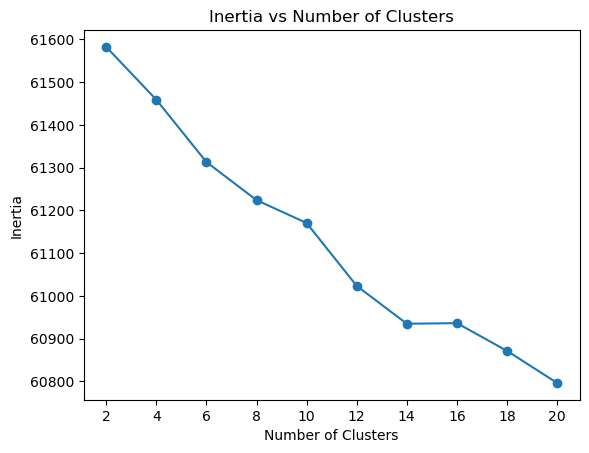

In [151]:
find_no_of_clusters(tfidvec_train2,20)

In [152]:
clusters = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048, random_state=39, max_iter=1000).fit_predict(tfidvec_train2)

In [153]:
label_order, accuracy = label_permute(review_short_df.category, clusters)
print('accuracy=', accuracy)

accuracy= 0.22508765976699469


In [154]:
get_top_keywords(tfidvec_train2, clusters, tfidvec2.get_feature_names_out(),10)

EMPOWERED VOICES
new, qa, time, valentines, week, business, men, mothers, women, day
SCIENCE & ENVIRONMENT
change, love, week, black, says, world, said, video, people, new
POLITICS
gop, said, campaign, says, president, hillary, trumps, clinton, donald, trump
PARENTING & EDUCATION
parenting, time, child, ago, new, school, children, parents, years, kids
TRAVEL & ART
need, want, make, things, dont, year, best, way, know, time
BUSINESS & MONEY
time, videos, dont, youtube, looking, know, going, thing, real, youre
SPORTS & ENTERTAINMENT
life, time, people, new, feel, dont, im, look, looks, like
LIFE & WELLNESS
sure, animal, want, pinterest, look, best, check, week, style, photos


# 4. Analysis

## - The best hyperparameter setting is as follows:
### TFIDF: max_df = 1, min_df = 2, ngram=1
### NMF: solver = ‘mu’, beta_loss = ‘kullback-leibler’
### -> The best accuracy is 0.3688…
## - Even this model does not work very well.
## - Compared with Kmeans, this NMF score is better.

## - The reason of not-good accuracy score assumes to be the similarity of word usage in different categories.
## - For example, ‘POLITICS’ or ‘PARENTING & EDUCATION’ might be well caught by this model.
## - But even seeing the wordcloud of original category such as ‘SPORTS & ENTERTAINMENT’ and ‘BUSINESS & MONEY’, we could not discern the difference.
## - In this sense, preprocess for removing common words should be essential for better accuracy.
## - This would be a future subject. 


# 5. Conclusion
## - In this project, we have executed clustering news articles by using NMF and TFIDF. 
## - The best accuracy is 0.3688, which estimates that it would not work very well.
## - Under unsupervised learning algorithm, this might be the limit.
## - In order for more accuracy, to remove common words would be essential.


## Reference
### https://www.kaggle.com/datasets/rmisra/news-category-dataset
### Misra, Rishabh. "News Category Dataset." arXiv preprint arXiv:2209.11429 (2022).
### Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).